In [11]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [12]:
import numpy as np
import pandas as pd

In [13]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [14]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [15]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [16]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [17]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [18]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [19]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

latest_Date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_Date

('2017-08-23')

In [24]:
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > '2016-08-22').all()

In [66]:
# Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.DataFrame(results, columns=['date', 'prcp'])
df.set_index('date', inplace=True)
df2 = df.rename(columns={"prcp":"Precipation"})
df2.head(10)

,Precipation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01
2016-08-29,0.00
2016-08-30,0.00
2016-08-31,0.13


In [68]:
# Sort the dataframe by date

df_sorted = df2.sort_values('date')
df_sorted = df_sorted.dropna(subset=['Precipation'])

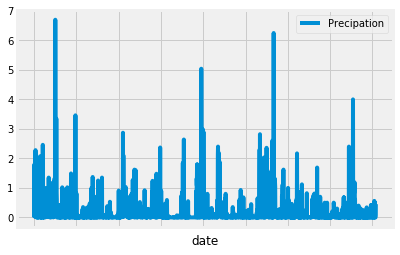

In [99]:
# Use Pandas Plotting with Matplotlib to plot the data

df_sorted.plot()

In [40]:
# Use Pandas to calcualte the summary statistics for the precipitation data

df_sorted.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?

session.query(Measurement.station).distinct(Measurement.station).count()

[(9)]

In [85]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

session.query(Measurement.station, func.count('*')).\
    group_by(Measurement.station).\
    having(func.count('*') > 1).\
    order_by(func.count('*').desc()).\
    all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [96]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

sel = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]

most_active = session.query(*sel).\
    filter(Measurement.station == "USC00519281").\
    all()
most_active

[(54.0, 85.0, 71.66378066378067)]

In [219]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

station = session.query(Measurement.tobs).\
            filter(Measurement.date > '2016-08-22').\
            filter(Measurement.station == 'USC00519281').\
            all()

In [220]:
df = pd.DataFrame(station)
df.head(10)

,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0
5,73.0
6,78.0
7,77.0
8,78.0
9,80.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022912E63CF8>]],
      dtype=object)

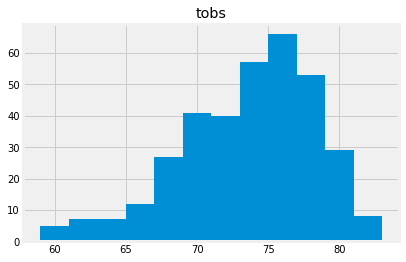

In [226]:
df.hist(bins=12)

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

my_trip = calc_temps('2017-01-01', '2018-01-01')

In [22]:
df = pd.DataFrame(my_trip, columns=['min', 'avg', 'max'])

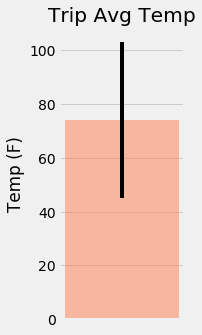

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

avg_temp = df.iloc[:,1]
min_temp = df.iloc[:,0]
max_temp = df.iloc[:,2]
tmax_tmin = max_temp - min_temp

plt.figure(figsize=(2,5))
plt.bar(0, avg_temp, yerr=tmax_tmin, color = 'coral', alpha=0.5)
plt.xticks([])
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.show()

In [34]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

result = session.query(Station.station, Station.name, func.sum(Measurement.prcp), Station.latitude, Station.longitude, Station.elevation).\
            filter(Measurement.date >= '2017-01-01').\
            filter(Measurement.date <= '2018-01-01').\
            group_by(Station.station).\
            order_by(func.sum(Measurement.prcp).desc()).\
            all()


print(result)

[('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 210.23000000000033, 21.3152, -157.9992, 0.9), ('USC00513117', 'KANEOHE 838.1, HI US', 210.23000000000033, 21.4234, -157.8015, 14.6), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 210.23000000000033, 21.5213, -157.8374, 7.0), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 210.23000000000033, 21.3331, -157.8025, 152.4), ('USC00517948', 'PEARL CITY, HI US', 210.23000000000033, 21.3934, -157.9751, 11.9), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 210.23000000000033, 21.4992, -158.0111, 306.6), ('USC00519281', 'WAIHEE 837.5, HI US', 210.23000000000033, 21.45167, -157.84888999999998, 32.9), ('USC00519397', 'WAIKIKI 717.2, HI US', 210.23000000000033, 21.2716, -157.8168, 3.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 210.23000000000033, 21.33556, -157.71139, 19.5)]


## Optional Challenge Assignment

In [61]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(60.0, 69.39622641509433, 77.0)]

In [91]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

date_range = []

start = dt.datetime.strptime("01-01", "%m-%d")
end = dt.datetime.strptime("01-07", "%m-%d")
date_generated = [start + dt.timedelta(days=x) for x in range(0, (end-start).days + 1)]

for date in date_generated:
        a = date.strftime("%m-%d")
        date_range.append(a)
    

result = []

for date in date_range:
    a = daily_normals(date)
    result.append(a)

result

[[(62.0, 69.15384615384616, 77.0)],
 [(60.0, 69.39622641509433, 77.0)],
 [(62.0, 68.9090909090909, 77.0)],
 [(58.0, 70.0, 76.0)],
 [(56.0, 67.96428571428571, 76.0)],
 [(61.0, 68.96491228070175, 76.0)],
 [(57.0, 68.54385964912281, 76.0)]]

In [160]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

df = pd.DataFrame(np.array(result).reshape(7,3), columns = list("abc"))
df2 = pd.DataFrame(date_range)

merged = pd.merge(df2, df, left_index=True, right_index=True)
merged = merged.rename(columns={'a':'tmin', 'b':'tavg', 'c':'tmax', 0:'date'})
merged = merged.set_index('date')
merged

,tmin,tavg,tmax
date,,,
01-01,62.0,69.153846,77.0
01-02,60.0,69.396226,77.0
01-03,62.0,68.909091,77.0
01-04,58.0,70.000000,76.0
01-05,56.0,67.964286,76.0
01-06,61.0,68.964912,76.0
01-07,57.0,68.543860,76.0


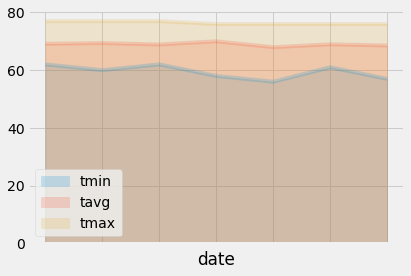

In [166]:
# Plot the daily normals as an area plot with `stacked=False`

merged.plot.area(stacked=False, alpha=0.2)